# Introduction to Automatic Speech Recognition

**Name**: 

This lab is an introduction to automatic speech recognition (ASR). In a nutshell, the ASR process consists of the following blocks:

1. **Feature extraction**: The audio waveform is preprocessed into normalized features such as spectrogram or MFCCs.
2. **Acoustic model**: The features are transformed into high-dimensional embeddings via a deep neural network (here: [wav2vec2](https://arxiv.org/pdf/2006.11477)), and then a classifier is applied to predict the class of each token (=character) at each time step.
3. **Decoding**: A transcript is generated from the sequence of class probabilities, either using a language model or not.

<center><a href="https://developer.nvidia.com/blog/how-to-build-domain-specific-automatic-speech-recognition-models-on-gpus/">
    <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2019/12/ASR-Pipeline-1.png" width="600"></a></center>
    
In this lab, we experiment with ASR using pretrained acoustic models (which include feature extraction for simplicity). We provide a dataset of real-life speech audio (with trancription) in order to study the influence of several factors onto the performance of a modern ASR system. We focus on the usage of the acoustic model, thus we use a simple decoder with no language model (this will be the topic of the next lab).

This series of lab relies on [torchaudio](https://pytorch.org/audio/stable/index.html), which is a pytorch-based librairy for audio/signal processing. More specifically, this lab is based on this [tutorial](https://pytorch.org/audio/stable/tutorials/speech_recognition_pipeline_tutorial.html#sphx-glr-tutorials-speech-recognition-pipeline-tutorial-py), which you are encouraged to check.
 

In [1]:
import torch
import torchaudio
import IPython
import os
import fnmatch
import matplotlib.pyplot as plt
torch.random.manual_seed(0)

MAX_FILES = 100 # lower this number for processing a subset of the dataset

## Load and display an audio example

Let us first load an audio file, listen to it using an audio reader, and plot the waveform.

In [2]:
# Dataset path (audio and transcripts)
data_speech_dir = "asr-dataset/speech/"
data_transc_dir = "/asr-dataset/transcription/"

In [23]:
# Example file
audio_file = 'asr-dataset/speech/61-70968-0001.wav'
waveform, sr = torchaudio.load(audio_file, channels_first=True)
IPython.display.Audio(data=waveform, rate=sr)

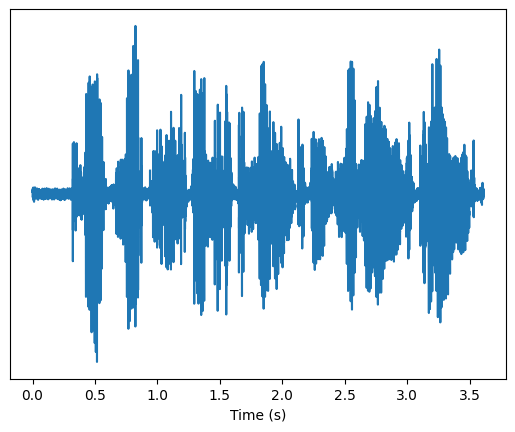

In [24]:
# Plot the speech signal waveform
plt.figure()
xt = torch.arange(waveform.size(1)) / sr
plt.plot(xt, waveform.T)
plt.yticks([])
plt.xlabel("Time (s)")
plt.show()

## Acoustic model

Let us create an acoustic model that performs feature extraction and classification. In this lab, we use [wav2vec2](https://arxiv.org/pdf/2006.11477), a self-supervised audio model that produces state-of-the-art results for many audio tasks (including ASR).

For convenience, both the model definition and pretrained wav2vec2 weights can be directly loaded using torchaudio, which includes two types of weights:
- The pretrained weights [without fine-tuning](https://pytorch.org/audio/stable/pipelines.html#id3), that can be fine-tuned for any other downstream tasks (e.g., emotion recognition or language detection).
- The pretrained weights that are [fine-tuned for the ASR task](https://pytorch.org/audio/stable/pipelines.html#id36), using an extra classification layer after feature extraction with wav2vec2.

In this series of lab, we use the latter. Below we provide the code for constructing a model and fetching the pretrained weights along with the classification labels. Here we use the `WAV2VEC2_ASR_BASE_100H` model. As the name indicates, it is a basic wav2vec2 architecture that is fine-tuned for ASR using 100 hours of the Librispeech dataset (containing both speech and transcriptions). Other models can be fetched using torchaudio (see the list [here](https://pytorch.org/audio/stable/pipelines.html#id36)).

In [25]:
# Load the acoustic model
model_name = 'WAV2VEC2_ASR_BASE_100H'
bundle = getattr(torchaudio.pipelines, model_name)
acoustic_model = bundle.get_model()

In [26]:
# Display the details of the model's architecture (more info on this in the Neural Network labs!)
print(acoustic_model)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [27]:
# Get and display the classification labels
labels = bundle.get_labels()
print('Labels:', labels)

Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


We can now apply the acoustic model to the example audio signal wa have loaded above. We can either compute the acoustic features or predicting the labels after the classification layer (also called the *emission* matrix/tensor):
- `features` is a list of tensors, where each tensor is the output of a transformer layer from the wav2vec2 model.

In [28]:
with torch.inference_mode():
    features, _ = acoustic_model.extract_features(waveform)

print(f"Number of transformer layers: {len(features)}")
print(features[0].shape)

Number of transformer layers: 12
torch.Size([1, 180, 768])


- `emission` is a tensor of size `[1, time steps, number of classes]` corresponding to the output of the classification layer (`1` corresponds to the batch size). Note that it is in the form of logits, not probabilities (thus it is not normalized in $[0, 1]$).

In [29]:
with torch.inference_mode():
    emission, _ = acoustic_model(waveform)

print(emission.shape)

torch.Size([1, 180, 29])


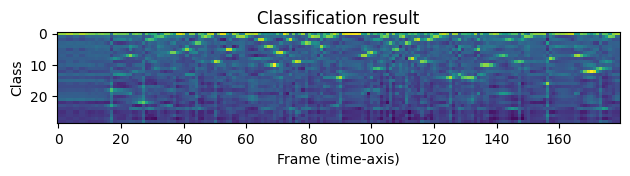

In [30]:
# Vizualize the result of the classification
plt.figure()
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

We can compute the most likely label at each time frame to get a first rough transcript estimate, as done below.

In [31]:
indices = torch.argmax(emission[0], dim=-1)  # take the most likely index at each time step
pred_labels = [labels[i] for i in indices] # transform each index into the corresponding label
print(pred_labels)

['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'G', '-', '-', '-', '-', '-', 'I', '-', '-', '-', 'V', '-', 'E', 'E', '-', '|', '|', '-', '-', 'N', 'N', '-', '-', '-', 'O', '-', '-', 'T', '-', '|', '|', '-', '-', 'S', '-', '-', '-', 'O', 'O', '-', '|', '|', '|', '-', '-', '-', '-', 'E', 'E', 'A', 'A', 'A', 'R', 'N', 'N', '-', '-', 'E', '-', 'S', 'S', '-', 'T', 'T', '|', '|', '|', 'A', '-', '|', '|', '-', '-', 'M', '-', '-', '-', '-', '-', '-', 'I', 'I', '-', 'N', '-', 'D', '-', '|', '-', 'T', '-', 'O', '|', '|', 'T', 'H', 'H', 'E', 'E', 'S', 'S', 'E', 'E', '|', '|', '-', '-', '-', 'M', '-', '-', 'U', 'M', 'M', 'M', 'M', '-', 'O', 'R', 'R', 'R', '-', '-', '-', 'I', 'I', 'E', 'E', '-', '-', 'S', '-', '|', '|', '-', '-', '-', '-', '-', 'C', 'H', '-', '-', '-', '-', '-', '-', '-', 'I', 'I', '-', 'L', 'L', 'L', 'L', '-', 'D', '-', '-', '|', '-', '-', '-']


Note that there are many blank labels `'-'`, as well as duplicates. This is why some further postprocessing / decoding is needed.

## Decoding

From the emission tensor, which is the sequence of probabilities (or logits) for each class / token, we now want to generate a transcript (or *hypothesis*). This process is called *decoding*. Decoding can be complex because it implies accounting for the context in order to avoid duplicates, assembling characters into words, identifying precise word start / end, and building sequences of words that make sense given some underlying language model.

Such refined decoding techniques involve using external ressources such as lexicon and language models. In this lab however, we rely on a naive approach called a *greedy* decoder, which does not depend on such components. The context information is not used (= we pick the best hypothesis at each time step), and only one transcript is generated by applying some basic post-processing (removing blank tokens and duplicates).

In [32]:
class GreedyDecoder(torch.nn.Module):
    def __init__(self, labels, blank_token_indx=0):
        super().__init__()
        self.labels = labels
        self.blank_token_indx = blank_token_indx

    def forward(self, emission):
        """Given a sequence emission over labels, decode the transcript
        Args:
          emission (Tensor): Logit tensors. Shape `[1, num_seq, num_label]`.
        Returns:
          transcript (List of strings): The resulting transcript
        """
        emission = emission[0] # take the first element in the batch (only one)
        indices = torch.argmax(emission, dim=-1)  # take the most likely index at each time step
        indices = torch.unique_consecutive(indices, dim=-1) # remove duplicates
        indices = [i for i in indices if i != self.blank_token_indx] # remove blank token
        transcript = "".join([self.labels[i] for i in indices]) # convert indices into tokens
        transcript = transcript.replace("|", " ").lower().split() # a bit of post-processing
        return transcript

In [33]:
# Instanciate the decoder, apply it, and display the result
decoder = GreedyDecoder(labels=labels)
est_transcript = decoder(emission)
print(est_transcript) #GIVE NOT SO EARNEST A MIND TO THESE MUMMERIES CHILD

['give', 'not', 'so', 'earnest', 'a', 'mind', 'to', 'these', 'mumories', 'child']


## Evaluation

To evaluate the quality of the transcript above, we need to compare it to some reference. More precisely, we can compute the [word error rate](https://en.wikipedia.org/wiki/Word_error_rate) (WER) between the reference and estimated transcripts. The WER is a measure of speech recognition performance expressed in % (lower is better) based on the Levenshtein distance, which allows to account for the fact that the true and estimated transcripts might have different lengths; more info in the course.

For the example we used until now, the true transcript is stored in the file `asr-dataset/transcription/61-70968-0001.txt` (note the file name is similar as the audio, except for the subfolder and extension).

<span style="color:red"> **Exercise 1**</span>. Load the content of this file to get the true transcript, and preprocess it to the same format as the estimated transcript above (i.e., use the `.lower()` and `.split()` methods). Display the true transcript. Then, using the provided `get_wer` function, compute and display 

In [45]:
with open('asr-dataset/transcription/61-70968-0001.txt', 'r') as f:
    true_transcript = f.readlines()
    true_transcript = true_transcript[0].strip().lower().split()
    print(true_transcript)

['give', 'not', 'so', 'earnest', 'a', 'mind', 'to', 'these', 'mummeries', 'child']


In [46]:
def get_wer(true_transcript, est_transcript):
    wer = torchaudio.functional.edit_distance(true_transcript, est_transcript) / len(true_transcript)
    return wer

In [47]:
wer = get_wer(true_transcript, est_transcript)
print(wer)

1.1


## Process a folder

<span style="color:red"> **Exercise 2**</span>. Process the entire dataset folder (=the 100 files) using the wav2vec2 acoustic model and the greedy decoder above, and compute and display the mean WER over the dataset.

In [37]:
# We provide a function below that returns the list of all files in a directory
def find_files(directory, pattern='*.wav'):
    """Recursively finds all files matching the pattern."""
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(filename)
    files = sorted(files)
    return files

# Get the list of audio files in the asr dataset
audio_files = find_files(data_speech_dir)
print(audio_files[:10])



['121-121726-0002.wav', '121-121726-0004.wav', '121-121726-0005.wav', '121-121726-0006.wav', '121-121726-0008.wav', '121-121726-0011.wav', '121-121726-0012.wav', '121-121726-0013.wav', '121-121726-0014.wav', '121-123852-0001.wav']


In [83]:

from pathlib import Path

# data_transc_dir = "./asr-dataset/transcription/"
path = '/home/oumar/School/Speech/asr-dataset/transcription/'
transcripts = []
for filename in os.listdir(path):
    if filename.endswith('.txt'):
        file_path = os.path.join(path, filename)

        with open(file_path, 'r') as f:
            data = f.readlines()
            data = data[0].strip().lower().split()
            # print(data)
            transcripts.append(data)
print(transcripts)

[['he', 'began', 'a', 'confused', 'complaint', 'against', 'the', 'wizard', 'who', 'had', 'vanished', 'behind', 'the', 'curtain', 'on', 'the', 'left'], ['hedge', 'a', 'fence'], ['silence', 'you', 'knave', 'cried', 'montfichet'], ['she', 'has', 'been', 'dead', 'these', 'twenty', 'years'], ['but', 'was', 'that', 'all', 'her', 'reward', 'one', 'of', 'the', 'ladies', 'asked'], ['hose', "man's", 'excuse', 'for', 'wetting', 'the', 'walk'], ['if', 'for', 'a', 'whim', 'you', 'beggar', 'yourself', 'i', 'cannot', 'stay', 'you'], ['dismiss', 'your', 'squire', 'robin', 'and', 'bid', 'me', 'good', 'e', 'e', 'n'], ['oh', 'no', 'jasper', 'i', 'must', 'go', 'by', 'my', 'very', 'own', 'self'], ['master', 'monceux', 'the', 'sheriff', 'of', 'nottingham', 'was', 'mightily', 'put', 'about', 'when', 'told', 'of', 'the', 'rioting'], ['surely', 'we', 'can', 'submit', 'with', 'good', 'grace'], ['like', 'as', 'not', 'young', 'master', 'though', 'i', 'am', 'an', 'old', 'man'], ['robin', 'entered', 'the', 'hut', '

In [84]:
# acoustic model on all the files 
for i, audio_file in enumerate(audio_files):
    waveform, sr = torchaudio.load(os.path.join(data_speech_dir, audio_file), channels_first=True)
    with torch.inference_mode():
        emission, _ = acoustic_model(waveform)
    est_transcript = decoder(emission)

    print(est_transcript)


        

['angor', 'hane', 'painful', 'to', 'hear']
['heaven', 'a', 'good', 'place', 'to', 'be', 'raised', 'to']
['hedge', 'offence']
['heredity', 'the', 'cause', 'of', 'all', 'our', 'faults']
['hos', "man's", 'excuse', 'for', 'wetting', 'the', 'walk']
['husband', 'the', 'next', 'thing', 'to', 'a', 'wife']
['hussy', 'woman', 'and', 'bond', 'tie']
['tied', 'to', 'a', 'woman']
['hypocrit', 'a', 'horse', 'dealer']
['i', 'me']
['the', 'story', 'is', 'written']
['the', 'others', 'resented', 'posponment', 'but', 'it', 'was', 'just', 'his', 'scruples', 'that', 'charmed', 'me']
['he', 'hung', 'fire', 'again', 'o', "woman's"]
['she', 'has', 'been', 'dead', 'these', 'twenty', 'years']
['she', 'sent', 'me', 'the', 'pages', 'ind', 'questiond', 'before', 'she', 'died']
['it', "wasn't", 'simply', 'that', 'she', 'said', 'so', 'but', 'that', 'i', 'knew', 'she', "hadn't", 'i', 'was', 'sure', 'i', 'could', 'see']
['you', 'are', 'accute']
['he', 'quitted', 'the', 'fire', 'and', 'dropped', 'back', 'into', 'his', '

## Influence of the noise

ASR systems are expected to be sensitive to the noise: while a model might work well on a clean recording, its performance will drop in real-life conditions where speech is contaminated with noise. We can simulate such a scenario by adding white noise to our speech waveforms.

The amount of noise is controlled by the *signal-to-noise ratio* (SNR), expressed in dB. The lower the SNR, the noisier the mixture: a clean speech signal corresponds to SNR=+$\infty$, while a pure noise signal corresponds to SNR=-$\infty$.

In [52]:
# The functions below allow to generate white noise, and add it to the clean speech at a certain SNR level

def adjust_noise_snr(
    speech,
    noise,
    snr_dB,
    silence_threshold=0.01,
):

    # Filter out silence from speech signal
    speech_wo_silence = speech[torch.abs(speech) > silence_threshold]

    # Calculate the total energy of the speech and noise signals
    speech_power = torch.sum(torch.square(speech_wo_silence))
    noise_power = torch.sum(torch.square(noise))

    # Compute gain factor to achieve desired SNR
    gain_factor = torch.sqrt((speech_power / noise_power) * 10 ** (-snr_dB / 10))

    # Scale the noise accordingly
    scaled_noise = gain_factor * noise

    return scaled_noise


def add_noise(speech, snr_dB=0):
    # Generate random white noise
    noise = torch.randn_like(speech)
    # Adjust noise level
    noise = adjust_noise_snr(speech, noise, snr_dB)
    # Add the noise to the clean speech
    speech_noisy = speech + noise
    return speech_noisy, noise

In [56]:
# Add noise to the original audio signal at SNR = 0 dB
speech_noisy_0dB, noise_OdB = add_noise(waveform, snr_dB=0)
IPython.display.Audio(data=speech_noisy_0dB, rate=sr)

In [57]:
# Add noise to the original audio signal at SNR = 5 dB
speech_noisy_5dB, noise_5dB = add_noise(waveform, snr_dB=5)
IPython.display.Audio(data=speech_noisy_5dB, rate=sr)

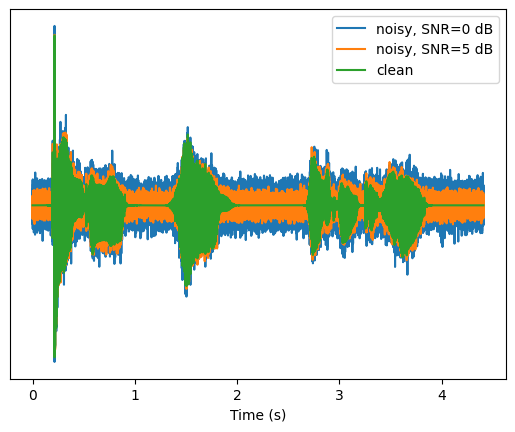

In [58]:
# Display the noisy signals (vs. the clean one)
plt.figure()
xt = torch.arange(waveform.size(1)) / sr
plt.plot(xt, speech_noisy_0dB.T, label='noisy, SNR=0 dB')
plt.plot(xt, speech_noisy_5dB.T, label='noisy, SNR=5 dB')
plt.plot(xt, waveform.T, label='clean')
plt.yticks([])
plt.xlabel("Time (s)")
plt.legend()
plt.show()

<span style="color:red"> **Exercise 3**</span>. For each SNR $\in [-5, 0, 5, 10]$ dB, add noise to the files in the dataset, perform ASR and compute/display the mean WER. Comment.

In [72]:
def asr_snr(snr):
    all_transcripts = [] 

    for i, audio_file in enumerate(audio_files):
        # Load audio file
        waveform, sr = torchaudio.load(os.path.join(data_speech_dir, audio_file), channels_first=True)
        
        # Add noise
        speech_noisy, noise = add_noise(waveform, snr_dB=snr)

        # Run inference
        with torch.inference_mode():
            emission, _ = acoustic_model(speech_noisy)

        # Decode the emission to get the transcript
        est_transcript = decoder(emission)
        
        # Append transcript to list
        all_transcripts.append(est_transcript)
    
    return all_transcripts

In [73]:
# snr = -5
print(asr_snr(-5))

[['ang', 'vav', 'vai', 'edar'], ['heaven', 'i', 'go', 'i', 'e', 'lat'], ['head', 'tut', 'te'], ['e', 'regity', 'tii', 'at', 'allo', 'ta'], ['nat', 'i', 'wi', 'lik', 'dol'], ['i', 'ti', 'venet', 'thik', 'yo', 'gie'], ['atey', 'women', 'and', 'a', 'i'], ['i', 'a', 'i'], ['if', 'a', 'tir', 'u', 'dealer'], ['i', 'b'], ['the', 'stoys', 'tite'], ['the', 'aters', 'itafot', 'but', 'it', 'i', 'e', 'ot'], ['e', 'i', 'di', 'agan', 'o', 'im'], ['i', 'it', 'te', 'deadi', 'i', 'de'], ['if', 'tat', 'ti', 'i', 'ee', 'te', 'te', 'lo', 'o', 'he', 'di'], ['e', 'eeiee'], ['hea'], ['eculd', 'if', 'i', 'i', 'drop', 'back', 'dan'], ['owobly', 'not', 'eefected', 'e'], ['i', 'wa', 'al', 'bo', 'ooeverybody', 'ba', 'ta'], ['by', 'the', 'ladyy', 'yo', 'theparte', 'oe', 'tit'], ['ibi', 'atat', 'at', 'e', 'bae', 'ly', 'life'], ['efo', 'tae'], ['i', 'doubt', 'hav', 'i'], ['he', 'lik', 'at', 'ca', 'tafetyof', 'otee'], ['god', 'it', 'i', 'i'], ['bu', 'wit', 'tat', 'da', 'we', 'we', 'al', 'wut', 'i', 'e', 'late', 'do']

In [74]:
# snr = 0
print(asr_snr(0))

[['angor', 'an', 'pa', 'go', 'to', 'beer'], ['heaven', 'a', 'god', 'plate', 'to', 'be', 'rate', 'to'], ['head', 'a', 'ten'], ['herebity', 'recards', 'of', 'allaur', 'tot'], ['ho', 'natyou', 'o', 'weckon', 'te', 'wall'], ["i'v", 'ben', 'the', 'next', 'think', 'your', 'wife'], ['athy', 'woman', 'and', 'bon', 'i'], ['tied', 'yoar', 'woman'], ['hypocrit', 'apot', 'dever'], ['i', 'b'], ['the', 'storys', 'witten'], ['the', 'addors', 'resented', 'pustonme', 'but', 'it', 'was', 'just', 'as', 'wit', 'with', 'the', 'charms', 'me'], ['he', 'hung', 'fir', 'again', 'a', 'woman'], ['he', 'gets', 'then', 'dead', 'e', 'twenty', 'yyears'], ['she', 'sent', 'me', 'thepageis', 'anquestion', 'before', 'she', 'died'], ['so', 'simply', 'that', 'you', 'said', 'so', 'athat', 'i', 'knew', "she'd", 'havin', 'i', 'wasure'], ['you', 'a'], ['he', 'quitted', 'the', 'fire', 'and', 'dropped', 'back', 'into', 'his', 'chair'], ['probably', 'not', 'tor', 'the', 'feckan', 'i'], ['it', 'was', 'al', 'my', 'petuntot', 'every

In [75]:
# snr = 5
print(asr_snr(5))

[['angor', 'pan', 'pango', 'to', 'beer'], ['heaven', 'a', 'grood', 'place', 'to', 'be', 'raised', 'to'], ['hedge', 'a', 'fence'], ['heredity', 'the', 'cause', 'of', 'all', 'our', 'falt'], ['hos', 'nat', 'excuse', 'for', 'wetking', 'te', 'walk'], ['husbeen', 'the', 'next', 'thing', 'to', 'a', 'wife'], ['hafee', 'woman', 'and', 'bon', 'tie'], ['te', 'tie', 'to', 'ar', 'woman'], ['hypocrit', 'acorse', 'dearler'], ['i', 'me'], ['the', 'story', 'is', 'written'], ['the', 'others', 'resented', 'posponient', 'but', 'it', 'was', 'just', 'a', 'scruple', 'the', 'charmed', 'me'], ['he', 'hung', 'fire', 'again', 'a', 'woman'], ['she', 'has', 'been', 'dead', 'these', 'twenty', 'years'], ['she', 'sant', 'meo', 'the', 'pages', 'in', 'questioned', 'before', 'she', 'died'], ['some', 'simply', 'that', 'she', 'said', 'so', 'that', 'i', 'knew', 'she', "hadn't", 'i', 'was', 'sure', 'i', 'could', 'see'], ['you', 'are', 'acute'], ['he', 'quitted', 'the', 'fire', 'and', 'dropped', 'back', 'into', 'his', 'chair

In [76]:
# snr = 10
print(asr_snr(10))

[['angor', 'pane', 'painful', 'to', 'hear'], ['heaven', 'a', 'good', 'place', 'to', 'be', 'raised', 'too'], ['hedge', 'a', 'fence'], ['heredity', 'the', 'cause', 'of', 'all', 'our', 'faults'], ['hers', "man's", 'excuse', 'for', 'wetting', 'the', 'walk'], ['husband', 'the', 'next', 'thing', 'to', 'a', 'wife'], ['hussy', 'woman', 'and', 'ban', 'tie'], ['tied', 'to', 'a', 'woman'], ['hypocrit', 'a', 'horse', 'dearler'], ['i', 'b'], ['the', 'story', 'is', 'written'], ['the', 'others', 'resented', 'posponment', 'but', 'it', 'was', 'justie', 'scruple', 'that', 'charmed', 'me'], ['he', 'hung', 'pire', 'again', 'a', "woman's"], ['she', 'has', 'been', 'dead', 'these', 'twenty', 'years'], ['she', 'sent', 'me', 'the', 'pages', 'in', 'questioned', 'before', 'she', 'died'], ['was', 'on', 'simply', 'that', 'she', 'said', 'so', 'ut', 'that', 'i', 'knew', 'she', "hadn't", 'i', 'was', 'sure', 'i', 'could', 'see'], ['you', 'are', 'accute'], ['he', 'quitted', 'the', 'fire', 'and', 'dropped', 'back', 'int

## Influence of the amount of training data

So far, we have used a model that was fine-tuned for ASR on 100 hours of speech, but alternative models exist in torchaudio (recall the list of pipelines is [here](https://pytorch.org/audio/stable/pipelines.html#id36)).

<span style="color:red"> **Exercise 4**</span>. Perform ASR on the dataset and compute the WER for models that are fine-tuned with either less or more speech data, and comment. Be careful of using models using the same architecture (basic wav2vec2) for a fair comparison.

Finally, note that many other pretrained models are readily available in torchaudio, such as a:
- larger models (e.g., `'WAV2VEC2_ASR_LARGE_10M'`)
- model trained using another dataset (e.g., `'WAV2VEC2_ASR_LARGE_LV60K_10M'`)
- alternative architectures (e.g., `'HUBERT_ASR_LARGE'`).

Feel free to experiment with these!